In [2]:
import sys
sys.path.append("../")
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trainbow.utils as utils
import os

import trainbow.features.intensity_features as int_features
import trainbow.visualizations.feature_plots as viz


import multiprocessing as mp
from tqdm import tqdm


In [3]:
plate_id = "PC2088"
nikon_channel_map = {"DAPI": 3, 
                    "WGA_488": 2,
                    "WGA_555": 1,
                    "Lysoview_630": 0}

tech_dev_channel_map = {"DAPI": 1, 
                        "WGA_488": 2,
                        "WGA_555": 0,
                        "Lysoview_630": 3}

well_map = {
            "DAPI" : ['A01','B01'],
            "DAPI+WGA488" : ['A02','B02'],
            "DAPI+WGA55" : ['A03','B03'],
            "DAPI+Lysoview633" : ['A04','B04'],
              
            "DAPI+WGA488+WGA55": ['C01','D01'],
            "DAPI+WGA488+Lysoview633": ['C02','D02'],
            "DAPI+WGA55+Lysoview633": ['C03','D03'],
            "DAPI+WGA55+WGA55+Lysoview633": ['C04','D04']}

bucket = 's3://insitro-user/'
output_dir = os.path.join('saradha/',plate_id)

In [4]:
## create aquisition dataframes for techdev and nikon microscopes
tech_dev_acquisition = utils.database_utils.create_acquistion_df(plate_id,6)
nikon_acquisition = utils.database_utils.create_acquistion_df(plate_id,2)

#drop duplicate file paths - keeping only the last row
tech_dev_acquisition = tech_dev_acquisition.drop_duplicates(subset='file_path', keep="last")
nikon_acquisition = nikon_acquisition.drop_duplicates(subset='path', keep="last")

For the plate id PC2088, 2 unique measurements were found


NoSuchTableError: programmable_angular_source_episcopic_modality_view

In [8]:
print("for the tech-dev acquisition,there are {} images across {} wells".format(
    len(tech_dev_acquisition.file_path.unique()),len(tech_dev_acquisition.well_loc.unique())))
print("for the nikon acquisition,there are {} images across {} wells".format(
    len(nikon_acquisition.path.unique()),len(nikon_acquisition.well_loc.unique())))

for the tech-dev acquisition,there are 2384 images across 16 wells
for the nikon acquisition,there are 1552 images across 16 wells


In [ ]:
def extract_features(args:list):
    
    input_image_path = args[1]
    uid = args[0]

    image = utils.database_utils.read_image(input_image_path)
    labelled_image = np.ones([image[channel_map['DAPI']].shape[0], image[channel_map['DAPI']].shape[1]])        

    
    feat = pd.concat([pd.DataFrame([uid],columns=["uid"]),
                      pd.DataFrame([int_features.histogram_feat(regionmask = labelled_image, 
                                                               intensity = image[channel_map['DAPI']])]).add_prefix('DAPI_').reset_index(drop=True),
                      pd.DataFrame([int_features.histogram_feat(regionmask = labelled_image, 
                                                               intensity = image[channel_map['WGA_488']])]).add_prefix('WGA_488_').reset_index(drop=True),
                      pd.DataFrame([int_features.histogram_feat(regionmask = labelled_image, 
                                                               intensity = image[channel_map['WGA_555']])]).add_prefix('WGA_555_').reset_index(drop=True),
                      pd.DataFrame([int_features.histogram_feat(regionmask = labelled_image, 
                                                               intensity = image[channel_map['Lysoview_630']])]).add_prefix('Lysoview_630_').reset_index(drop=True)
                      
                     
                     ], axis = 1)
    del image,labelled_image
    return feat

def plot_median_feature_heatmap(feat:str,dataset:pd.DataFrame):
    features = [sub + "_" + feat for sub in list(channel_map.keys())]

    cols_to_select = [sub + "_" + feat for sub in list(channel_map.keys())[1:4]]

    feature_matrix = pd.DataFrame()
    for feature in features:
        agg_data = dataset.groupby(['well_loc'],as_index=False).median()
        population = pd.DataFrame()
        for sample in list(well_anno.keys()):
            population  = pd.concat([population,
                                    pd.DataFrame([{'sample' : sample,
                                                  'feature' : np.mean(agg_data[agg_data.well_loc.isin(well_anno[sample])][feature])
                                                 }]).reset_index(drop=True)])
        mat = np.array(list(population['feature'])).reshape(-1, 8)
        matrix = pd.DataFrame(mat, columns=population['sample'], index = [feature])
        #matrix = (matrix.T/list(np.sum(matrix,axis = 1))).T
        feature_matrix = pd.concat([feature_matrix,matrix])

    mat = feature_matrix.T
    fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
    im = ax.imshow(mat, cmap='coolwarm', interpolation='nearest')

    ax.set_xticks(np.arange(mat.shape[1]), labels = list(mat.columns))
    ax.set_yticks(np.arange(mat.shape[0]), labels = list(mat.index))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    fig.tight_layout()
    plt.show()
    
    

## Nikon scope

In [74]:
acquisition_df = nikon_acquisition
well_anno = nikon_well_map
channel_map = nikon_channel_map

1 4


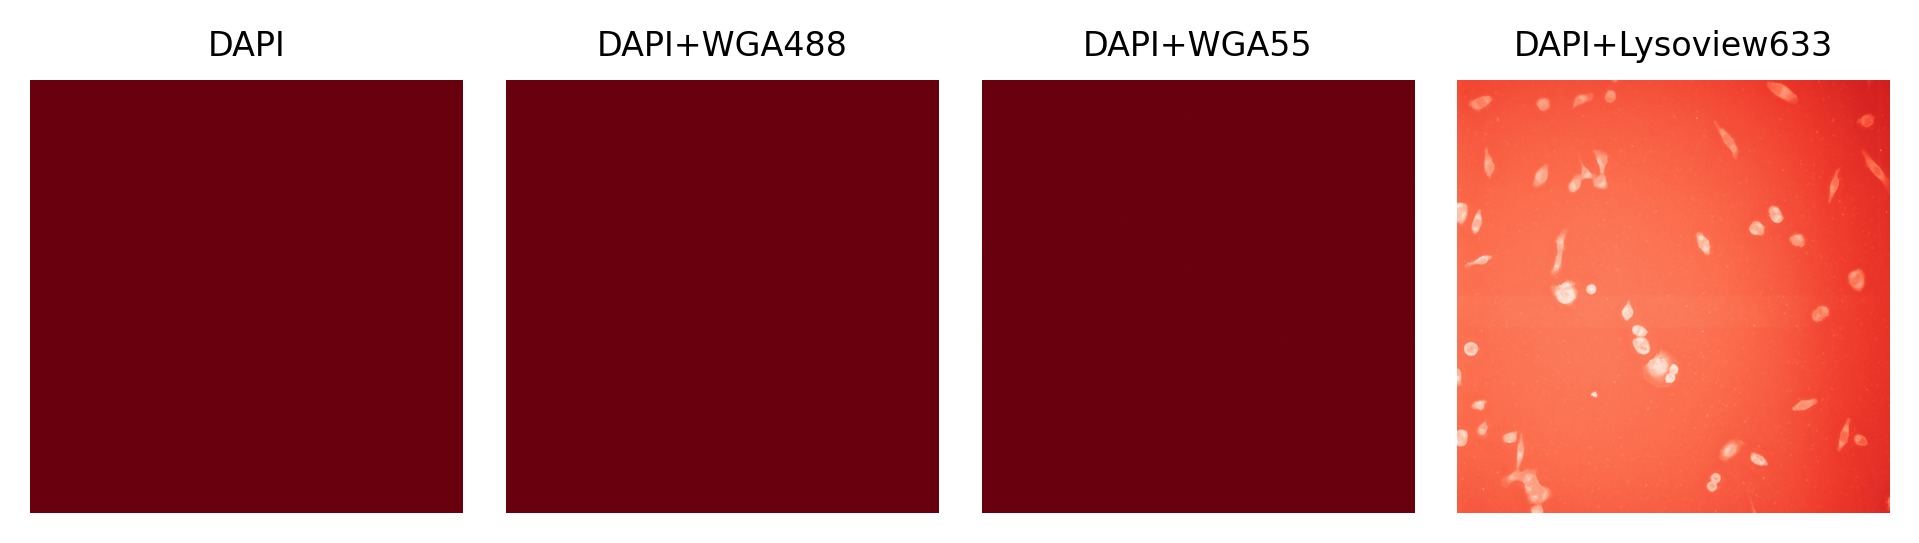

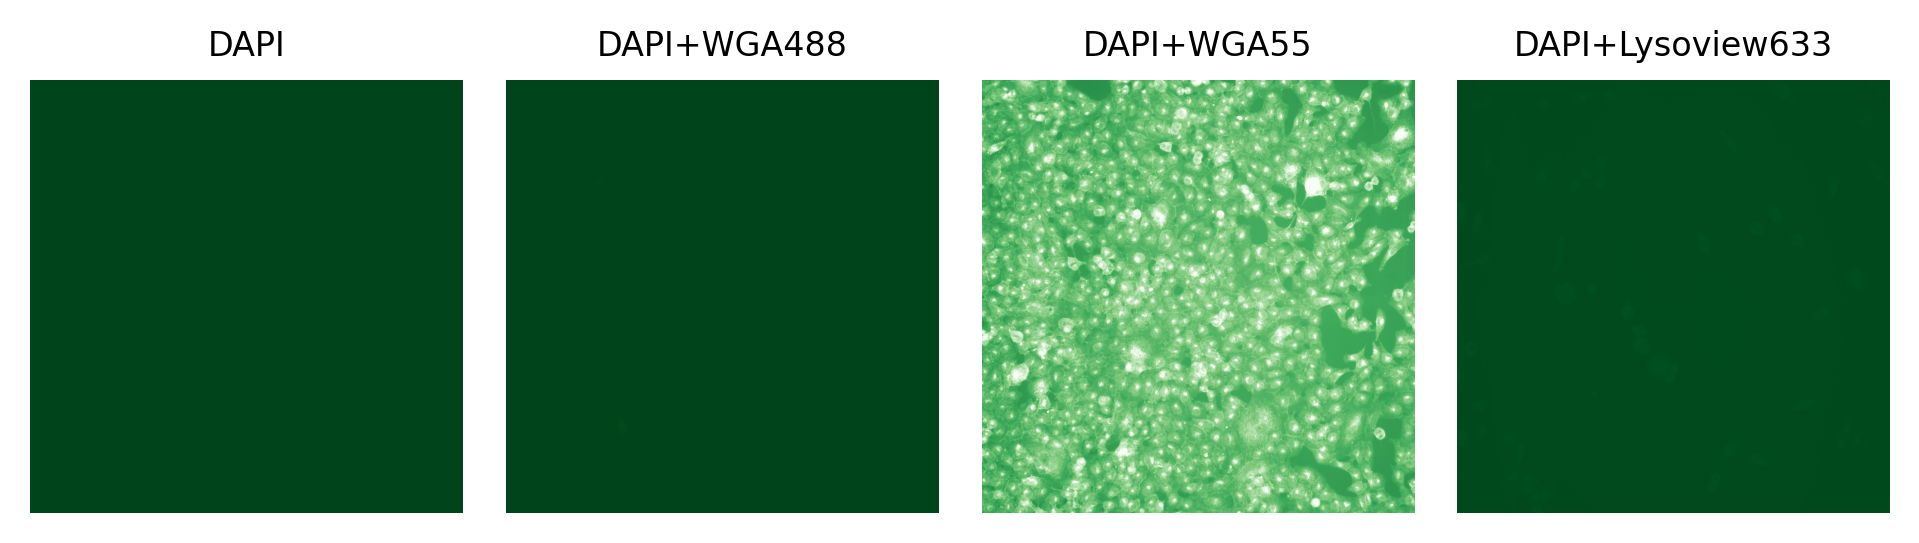

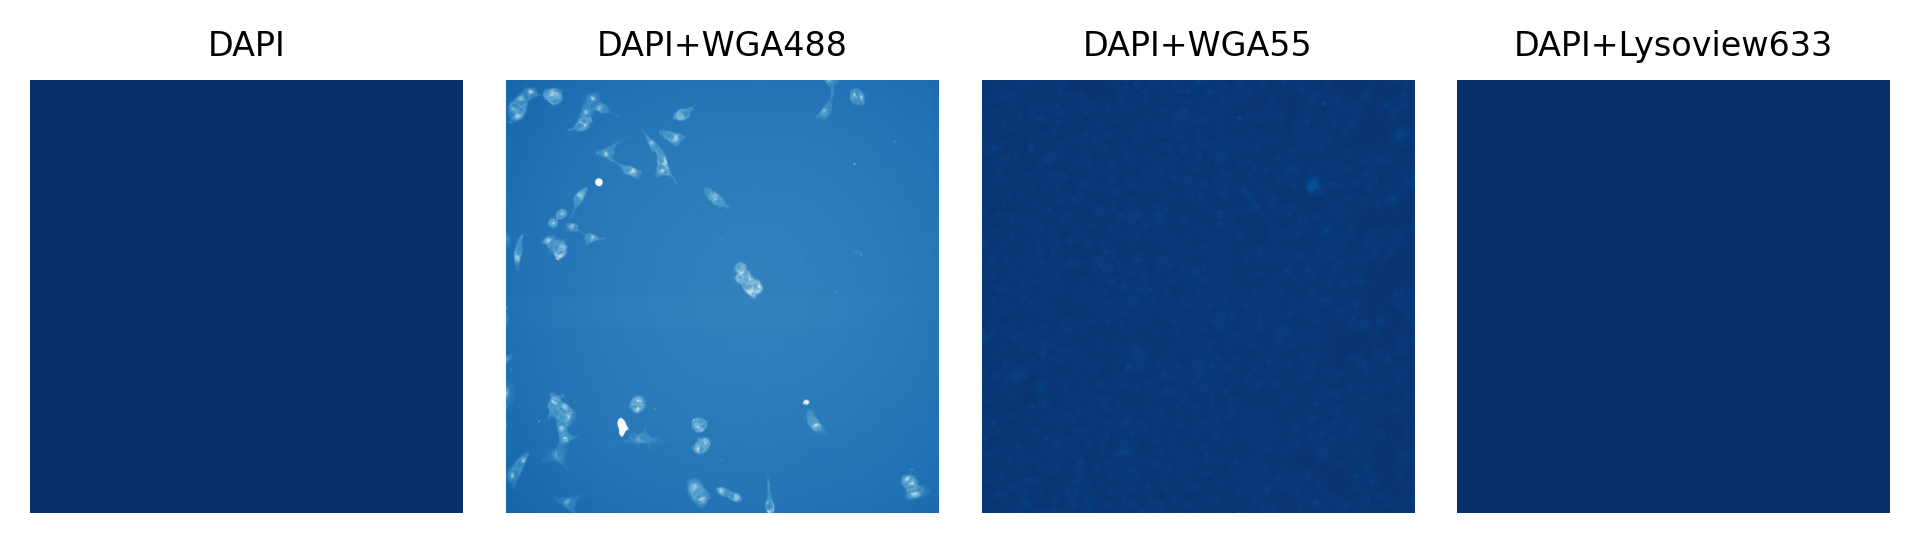

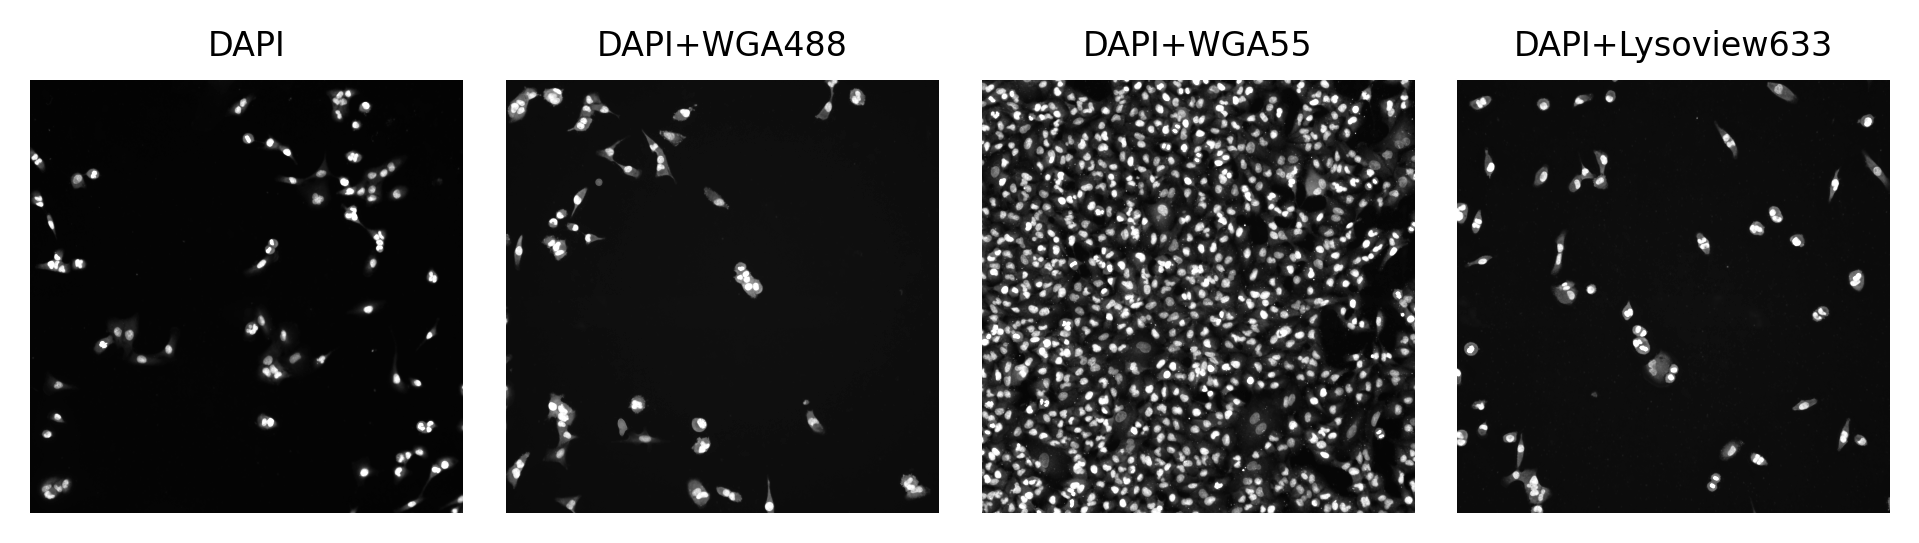

In [28]:
#Maximum instensity values
DAPI_max = 0
WGA_488_max = 0
WGA_555_max = 0
Lysoview_630_max = 0 

images = {} # initialise an empty dict

samples = ["DAPI" ,"DAPI+WGA488","DAPI+WGA55","DAPI+Lysoview633"]

for sample in list(well_anno.keys()):
    #select a random image in a random well for a given sample
    image_path = np.random.choice(acquisition_df[acquisition_df.well_loc == np.random.choice(well_anno[sample])].path)
    # read in the image
    image = utils.database_utils.read_image(image_path)
    #create composite image
    comp = np.stack([image[channel_map['DAPI']],
                     image[channel_map['WGA_488']],
                     image[channel_map['WGA_555']],
                     image[channel_map['Lysoview_630']]],
                            axis =2)
    #asess the maximum intensity values for the channels
    DAPI_max         = max(DAPI_max,np.max(comp[:,:,0]))
    WGA_488_max      = max(WGA_488_max,np.max(comp[:,:,1]))
    WGA_555_max      = max(WGA_555_max,np.max(comp[:,:,2]))
    Lysoview_630_max = max(WGA_555_max,np.max(comp[:,:,3]))
    images[sample] = comp
    
    
#set the layout of the image
nrow = 1
ncol = 4
print(nrow,ncol)

# visualise the expression of each flurophore for each sample
fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(well_anno.keys())):
    ax.imshow(images[sample][:,:,3],vmin =0, vmax = int(0.7*Lysoview_630_max),cmap ="Reds_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(well_anno.keys())):
    ax.imshow(images[sample][:,:,2],vmin =0, vmax = int(0.7*WGA_555_max),cmap ="Greens_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(well_anno.keys())):
    ax.imshow(images[sample][:,:,1],vmin =0, vmax = int(0.7*WGA_488_max),cmap ="Blues_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(well_anno.keys())):
    ax.imshow(images[sample][:,:,0],vmin =0, vmax = int(0.7*DAPI_max),cmap ="Greys_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

In [103]:
# extract features
image_uids = list(acquisition_df.uid.unique())
img_file_paths = list(acquisition_df[acquisition_df.uid.isin(image_uids)].path)
input_paths = np.column_stack([image_uids,img_file_paths])
#pool across multiple cpus
pool = mp.Pool(15)
features = list(tqdm(pool.imap(extract_features, [paths for paths in input_paths]), total = len(image_uids)))
pool.close()
pool.join()
features = pd.concat(features)

 19%|███████▌                                | 295/1552 [02:20<10:00,  2.09it/s]Process ForkPoolWorker-75:
Process ForkPoolWorker-72:
Process ForkPoolWorker-68:
Traceback (most recent call last):
Process ForkPoolWorker-73:
Traceback (most recent call last):
Process ForkPoolWorker-81:
Process ForkPoolWorker-82:
Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-76:
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ec

KeyboardInterrupt: 

  File "/home/ec2-user/insitro/trainbow/trainbow/features/intensity_features.py", line 38, in histogram_feat
    "int_mean": np.mean(foreground_pixels),
  File "/tmp/ipykernel_29603/2749691084.py", line 13, in extract_features
    pd.DataFrame([int_features.histogram_feat(regionmask = labelled_image,
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<__array_function__ internals>", line 5, in mean
  File "/home/ec2-user/miniconda3/envs/ins

  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/site-packages/numpy/lib/function_base.py", line 4036, in _quantile_ureduce_func
    ap = a.flatten()
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/site-packages/numpy/lib/function_base.py", line 3867, in percentile
    return _quantile_unchecked(
KeyboardInterrupt
  File "/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/site-packages/numpy/lib/function_base.py", line 3986, in _quantile_unchecked
    r, k = _ureduce(a, func=_quantile_ureduce_func, q=q, axis=axis, out=out,
  File "/tmp/ipykernel_29603/2749691084.py", line 13, in extract_features
    pd.DataFrame([int_features.histogram_feat(regionmask = labelled_i

In [76]:
dataset_nikon = pd.merge(features, acquisition_df, on='uid', how='outer')

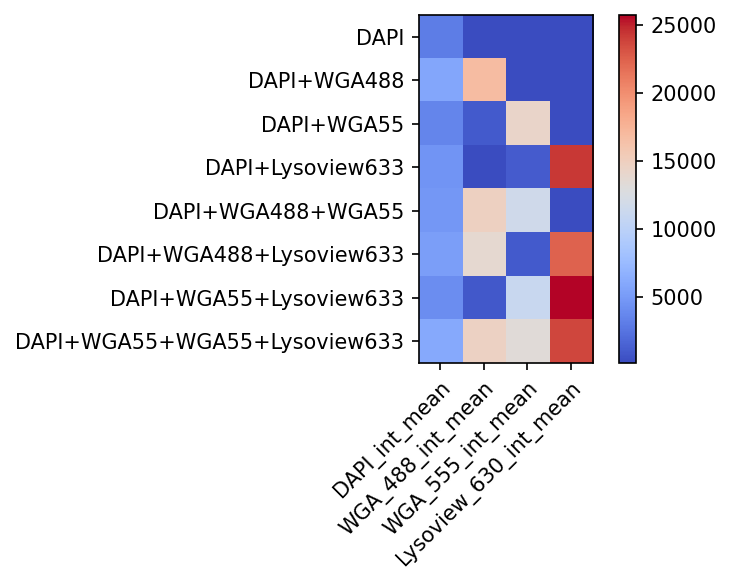

In [151]:
plot_median_feature_heatmap("int_mean",dataset_nikon)

## Techdev scope

In [153]:
acquisition_df = tech_dev_acquisition
well_anno = nikon_well_map
channel_map = channel_map_tech_dev

1 4


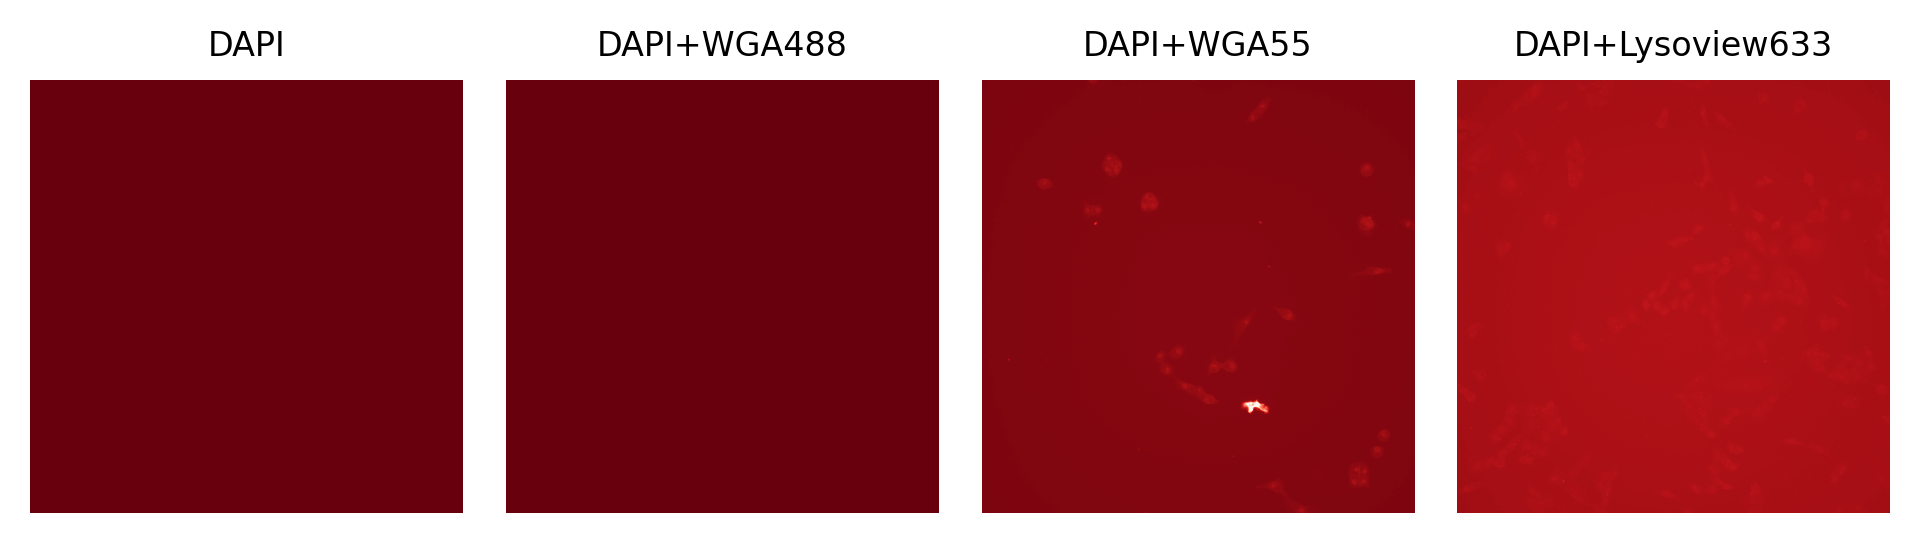

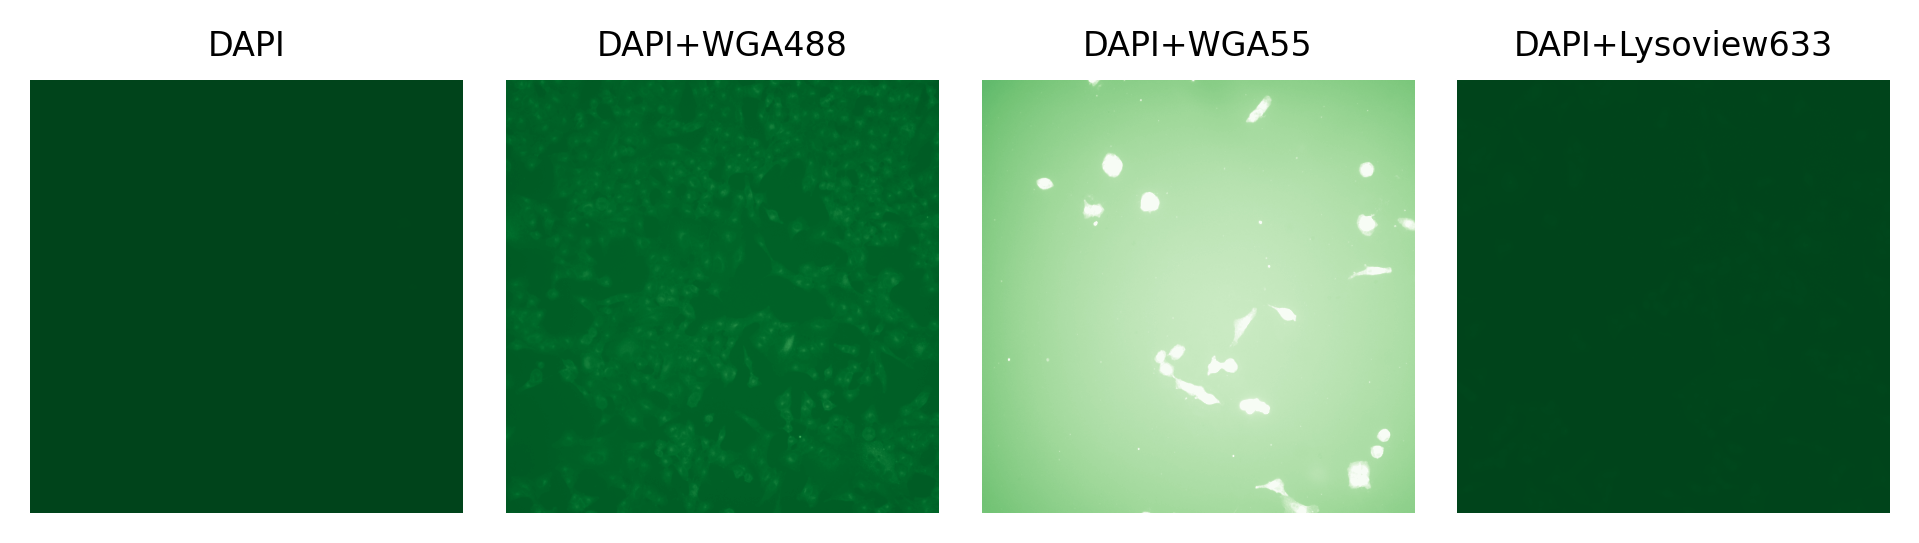

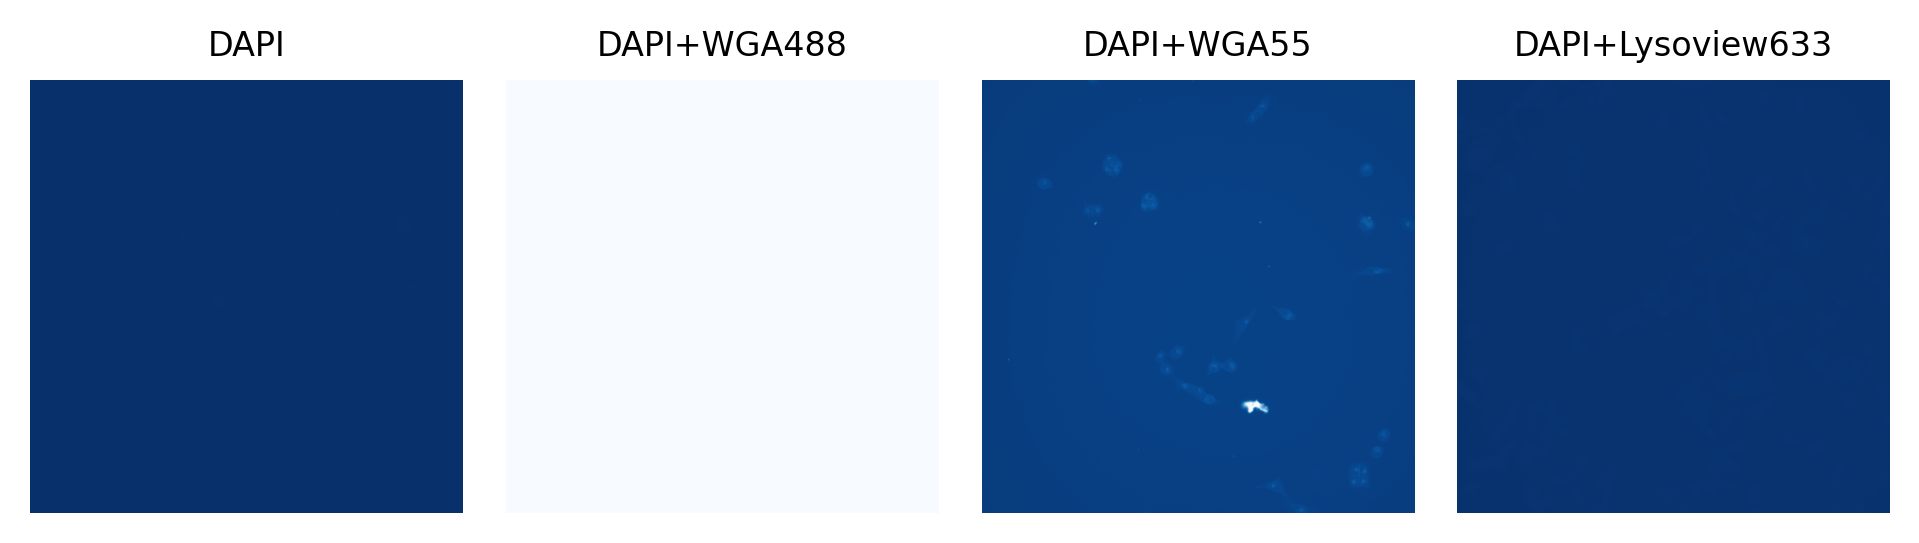

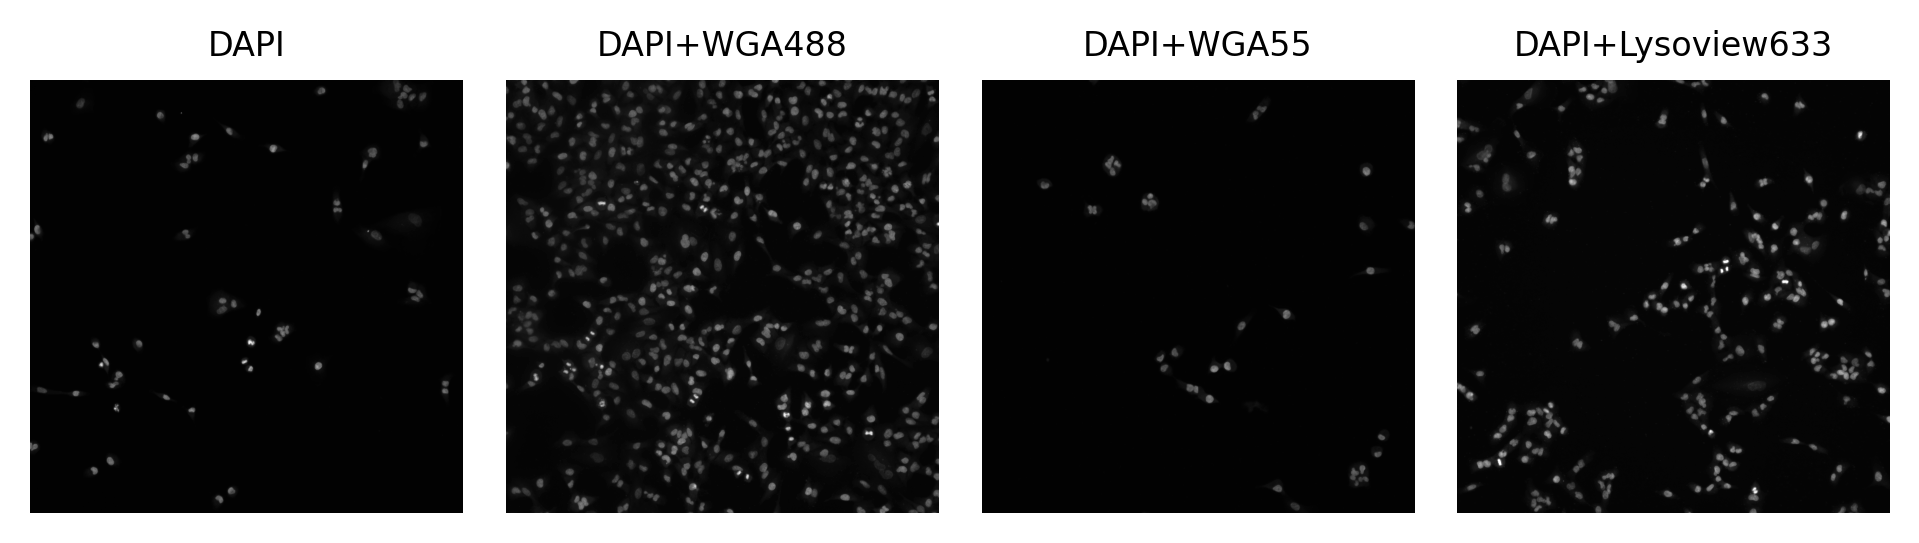

In [163]:
#Maximum instensity values
DAPI_max = 0
WGA_488_max = 0
WGA_555_max = 0
Lysoview_630_max = 0 

images = {} # initialise an empty dict

samples = ["DAPI" ,"DAPI+WGA488","DAPI+WGA55","DAPI+Lysoview633"]

for sample in list(samples):
    #select a random image in a random well for a given sample
    image_path = np.random.choice(acquisition_df[acquisition_df.well_loc == np.random.choice(well_anno[sample])].file_path)
    # read in the image
    image = utils.database_utils.read_image(image_path)
    #create composite image
    comp = np.stack([image[channel_map['DAPI']],
                     image[channel_map['WGA_488']],
                     image[channel_map['WGA_555']],
                     image[channel_map['Lysoview_630']]],
                            axis =2)
    #asess the maximum intensity values for the channels
    DAPI_max         = max(DAPI_max,np.max(comp[:,:,0]))
    WGA_488_max      = max(WGA_488_max,np.max(comp[:,:,1]))
    WGA_555_max      = max(WGA_555_max,np.max(comp[:,:,2]))
    Lysoview_630_max = max(WGA_555_max,np.max(comp[:,:,3]))
    images[sample] = comp
    
    
#set the layout of the image
nrow = 1
ncol = 4
print(nrow,ncol)

# visualise the expression of each flurophore for each sample
fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(samples)):
    ax.imshow(images[sample][:,:,3],vmin =0, vmax = int(0.7*Lysoview_630_max),cmap ="Reds_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(samples)):
    ax.imshow(images[sample][:,:,2],vmin =0, vmax = int(0.7*WGA_555_max),cmap ="Greens_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(samples)):
    ax.imshow(images[sample][:,:,1],vmin =0, vmax = int(WGA_488_max),cmap ="Blues_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()

fig, axs = plt.subplots(nrow,ncol, dpi = 300, figsize=(2*ncol,2*nrow))
fig.subplots_adjust(hspace = 0.2, wspace= 0.1)
for ax,sample in zip(axs.ravel(),list(samples)):
    ax.imshow(images[sample][:,:,0],vmin =0, vmax = int(0.7*DAPI_max),cmap ="Greys_r")
    ax.axis('off')
    ax.set_title(sample, fontsize=8)

fig.show()





In [165]:
# extract features
image_uids = list(acquisition_df.uid.unique())
img_file_paths = list(acquisition_df[acquisition_df.uid.isin(image_uids)].file_path)
input_paths = np.column_stack([image_uids,img_file_paths])
#pool across multiple cpus
pool = mp.Pool(15)
features = list(tqdm(pool.imap(extract_features, [paths for paths in input_paths]), total = len(image_uids)))
pool.close()
pool.join()
features = pd.concat(features)
dataset_techdev = pd.merge(features, acquisition_df, on='uid', how='outer')

100%|███████████████████████████████████████| 2384/2384 [22:51<00:00,  1.74it/s]


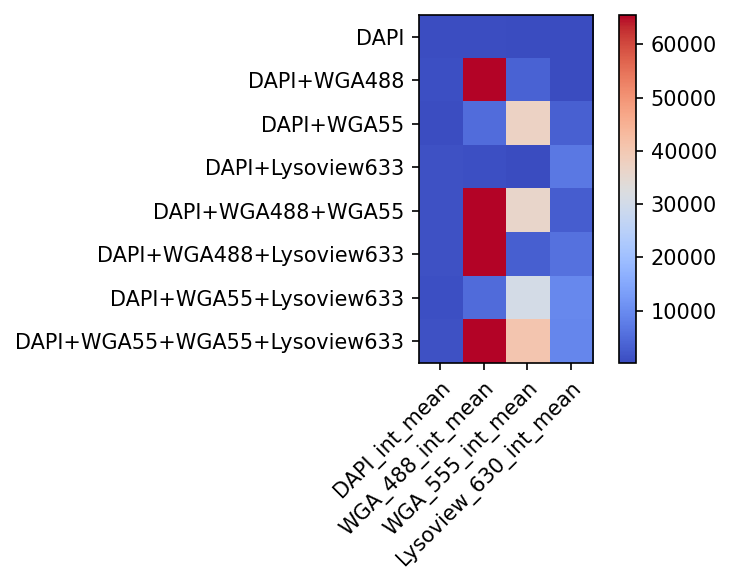

In [167]:
plot_median_feature_heatmap("int_mean",dataset_techdev)